In [78]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import model_evaluation_utils as meu 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 200
%matplotlib inline

## 1. Reading in the data

In [18]:
path1 = '/Users/Alexandra/Desktop/REPOS/Springboard_DS/CAPSTONE_2/CAP_2/gtd_95to12_0617dist.csv'

df = pd.read_csv(path1, encoding = "ISO-8859-1") #learn for later

/Users/Alexandra/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,6,33,61,62,63,76,79,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
path = '/Users/Alexandra/Desktop/REPOS/Springboard_DS/CAPSTONE_2/CAP_2/gtd_13to16_0617dist3.csv'

df1 = pd.read_csv(path, encoding = "ISO-8859-1") #learn for later

/Users/Alexandra/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,20,21,22,23,25,26,27,28,30,32,33,34,36,40,42,44,48,50,51,52,53,54,55,56,57,61,62,63,65,66,67,68,69,70,71,72,74,75,76,77,78,79,80,81,83,85,87,89,91,93,94,95,96,98,99,100,101,102,103,104,105,107,109,110,111,112,113,114,115,116,117,118,119,120,121,122,124,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,303,

### 2. Preprocessing

Getting rid of NaNs from our summary, we want everything in df['summary'] to be of same type

In [20]:
summary_list = []

for item in df['summary']:
    if type(item) == float:
        item = ''
    summary_list.append(item)

In [21]:
# confirming they are the same size

len(summary_list), len(df)

(55055, 55055)

In [22]:
# setting the df column = to the list 

df['summary'] = summary_list

In [23]:
print(len(df.columns))
print(len(df1.columns))

135
824


In [24]:
# true / false
print(list(df1.columns[0:135]) == list(df.columns[0:135]))
print(list(df1.columns[0:134]) == list(df.columns[0:134]))
print(list(df1.columns[0:133]) == list(df.columns[0:133]))

False
False
True


we see the first 133 columns are the same between the two dataframes

#### why do we decide to only read in the two most recent ?

according to GDT https://www.start.umd.edu/gtd/downloads/Codebook.pdf the "doubtterr" key is only available after 1997, also we feel that the groups change a bit frequently over the years and do not last very long so possibly just the recent two databases is neccessary.

##### Concatenating: 
Before Attempting to concatenate the two data frames, since they have different column names, we need to use the first 133 columns and we will anaylyze which features have the correctly structured data and consistent data types to be easily fed into a model

In [25]:
# only keeping the first 133 column because these are the same 

df = df.filter(items = list(df.columns[0:133]))
df1 = df1.filter(items = list(df.columns[0:133]))

In [26]:
df = df.append(df1) # combining the two

##### the doubtterr indicator:

according to GDT https://www.start.umd.edu/gtd/downloads/Codebook.pdf the "doubtterr" indicator tells us whether there is doubt it was a terrorist attack or not. we only want to train our model on accurate data so we will filter out the 1's which indicate that 

In [27]:
df = df[df['doubtterr'] == 0]
df = df[df['gname'] != 'Unknown']
len(df)

34115

In [28]:
df = df.reset_index(drop = True)

In [29]:
len(df['gname'])

34115

In [30]:
#feature importance plot
#roc curve for best model

# Some EDA: looking at group name occurences

In [31]:
threshold = 40

gname_list = list(df['gname'].value_counts().index)    # wrapping the total names in a list

value_list = df['gname'].value_counts() # getting values
occ_list = list(df['gname'].value_counts())

group_names = value_list[value_list.values > threshold].index 
values = list(value_list[value_list.values > 40])

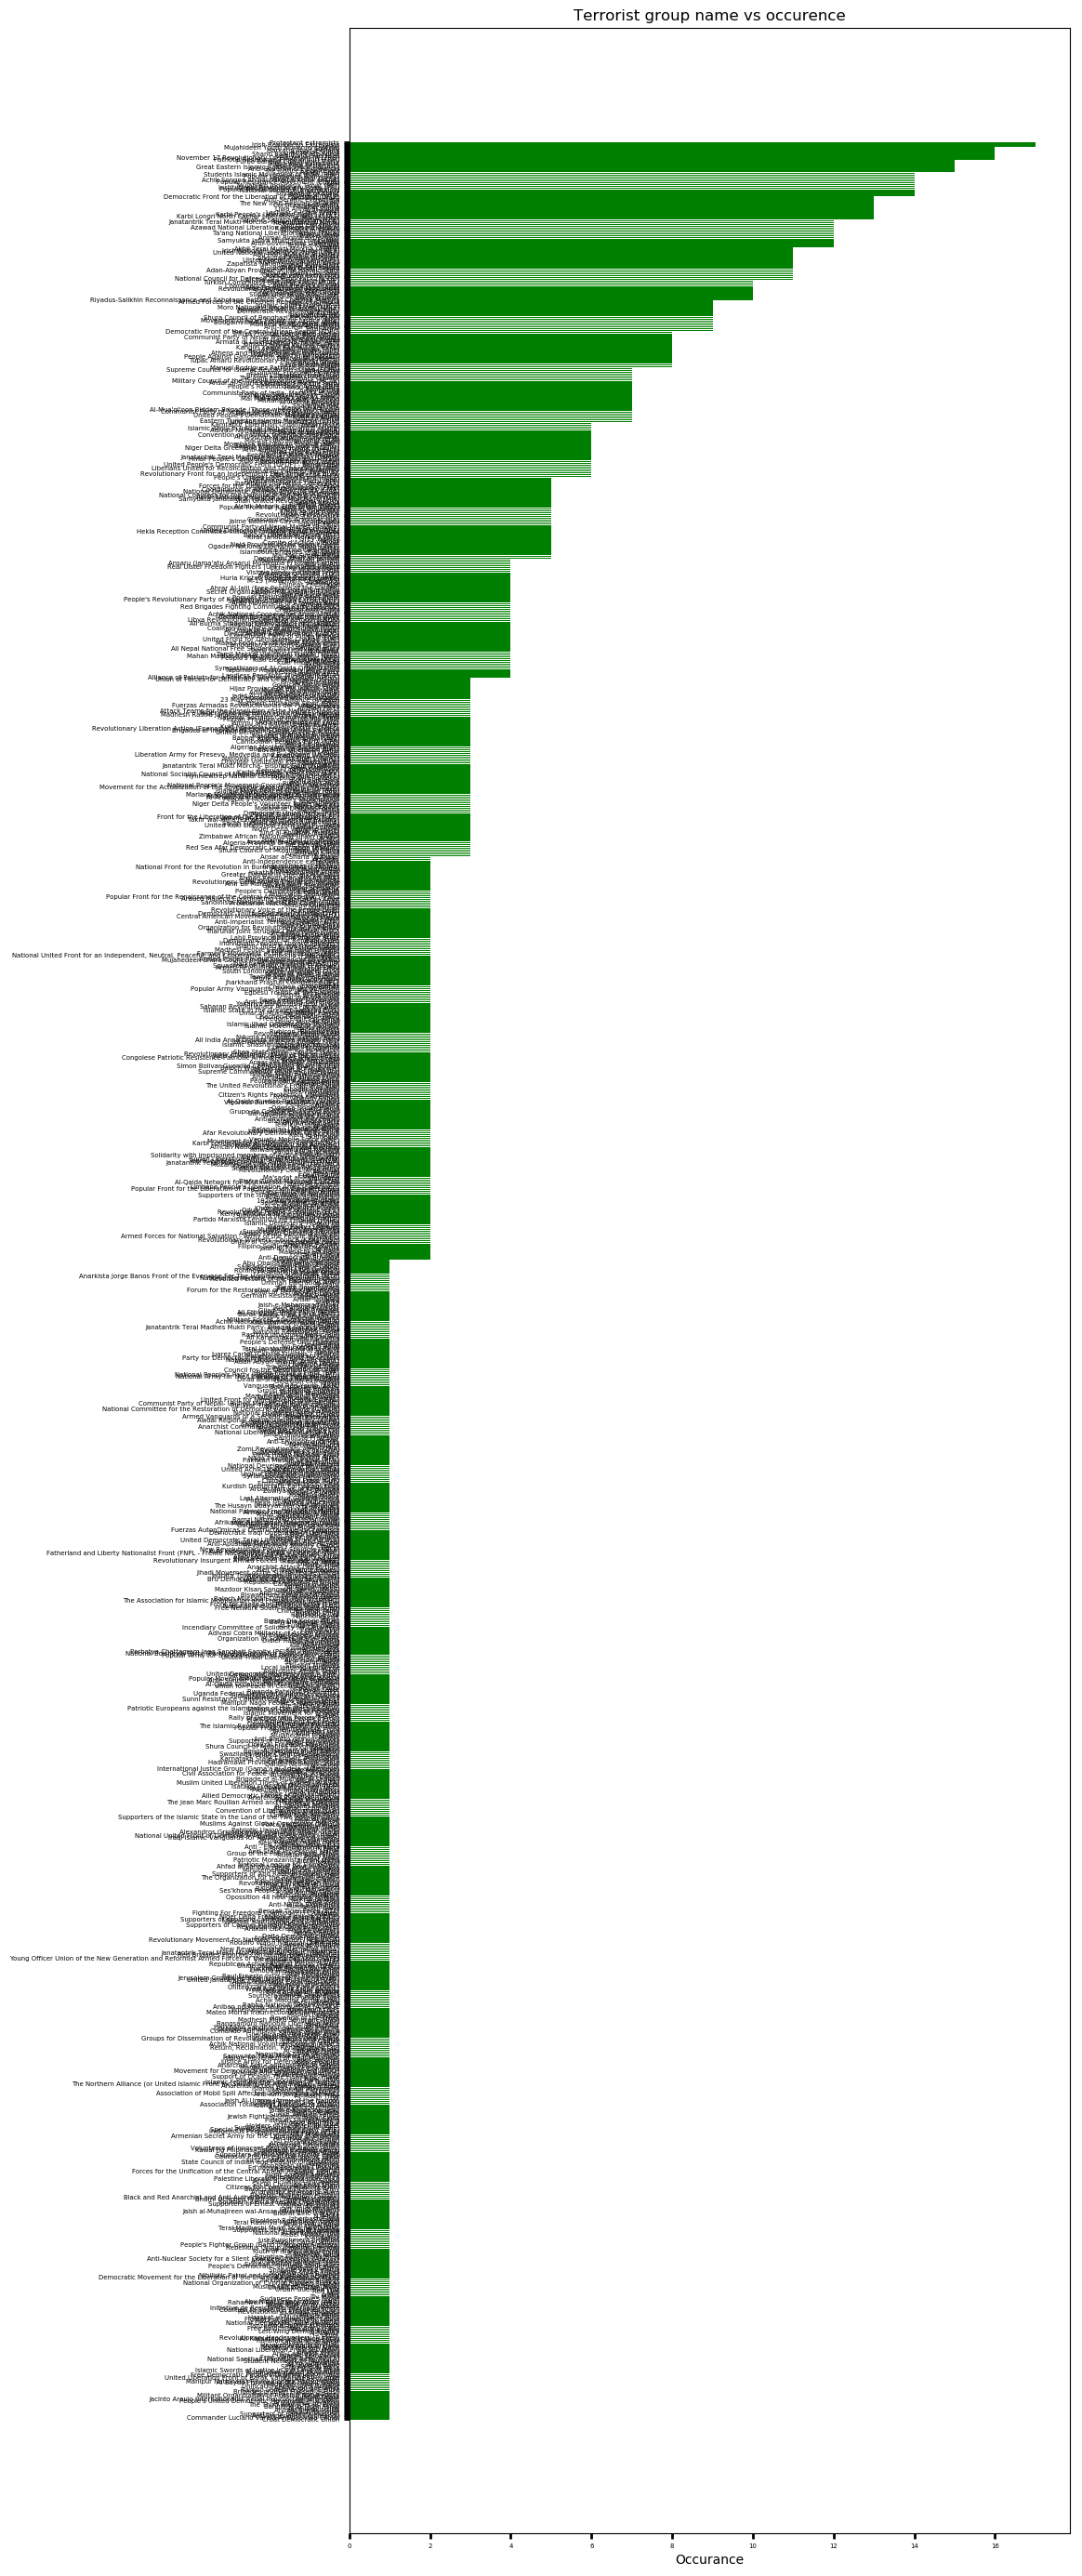

In [32]:
# Fixing random state for reproducibility
np.random.seed(19680801)
plt.rcdefaults()
#plt.figure(figsize=(35,10))
fig, ax = plt.subplots(figsize=(10,35))
# Example data
glist = gname_list[180:]
y_pos = np.arange(len(glist))
#error = np.random.rand(len(people))
error = 0
ax.barh(y_pos, occ_list[180:], xerr=error, align='center',
        color='green', ecolor='black')
ax.tick_params(direction='out', length=4, width=2, labelsize = 5, colors='black',
               grid_color='r', grid_alpha=0.5)
#ax.set_xbound(0,5)
ax.set_yticks(y_pos)
ax.set_yticklabels(glist)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurance')
ax.set_title('Terrorist group name vs occurence')

plt.show()

##  Model Accuracy vs. Occurence Threshold:
We realized that there were many group labels with just one occurence, we definitley needed to scrap those, because it is certain they will cause errors. what is meant by that more explicitly is that, if we only have a label with one occurence, it will either end up in the test data set or the train data set. If it ends up in the test data set the model will have no training on this instance and will certainly wrongly predict it's label. 

That being said, we can discard the group names that only have 1 occurence, but we can also choose to discard group names with "5 or less occurences" because we know the likelihood of a group name with 5 or less occurences all going into either the test section or the train section upon splitting, is a fairly high probablilty. In either case, the accuracy would be affected.

We decide to test out a few thresholds in when we should training/testing ona a label label, we ran the model 4 times in other notebooks, at 4 different thresholds, being 5, 20, 30 and 40, and we plotted the corresponding accuracies.  

here is accuracy vs 'occurence threshold number' line graph scatterplot, we can see accuracy increases as we make our threshold higher, which makes sense because a model trained on more data for a certain group, will have higher accuracy at being able to predict that group if the group came up in the test set. 

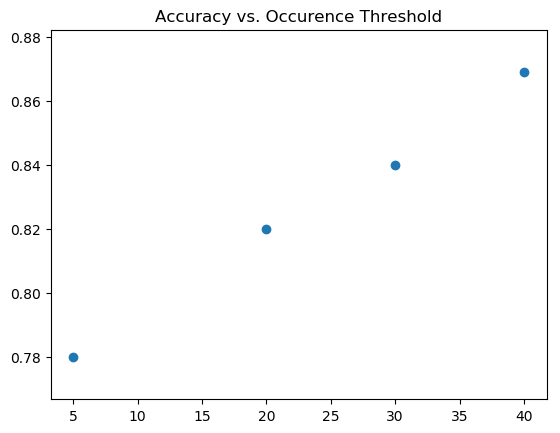

In [33]:
x = [5, 20, 30, 40]
y = [0.78, 0.82, 0.84, 0.869]
fig, ax = plt.subplots()
plt.scatter(x, y) #s=None, c=None, marker=None)
plt.title('Accuracy vs. Occurence Threshold')
plt.show()
fig.savefig('accuracy.png')

we can see the correlation is linear with the threshold that we decide to pick for how many occurences in the train-test data set 

##### we will proceed in the notebook using 40 as our threshold as seen in the cell below but this number may be changed to reproduce any of the above data points.

In [34]:
threshold = 40

gname_list = list(df['gname'].value_counts().index)    # wrapping the total names in a list

value_list = df['gname'].value_counts() # getting values
occ_list = list(df['gname'].value_counts())

group_names = value_list[value_list.values > threshold].index 
values = list(value_list[value_list.values > 40])

#### now that we chopped down our dataframe we can look at the distribution of the groups

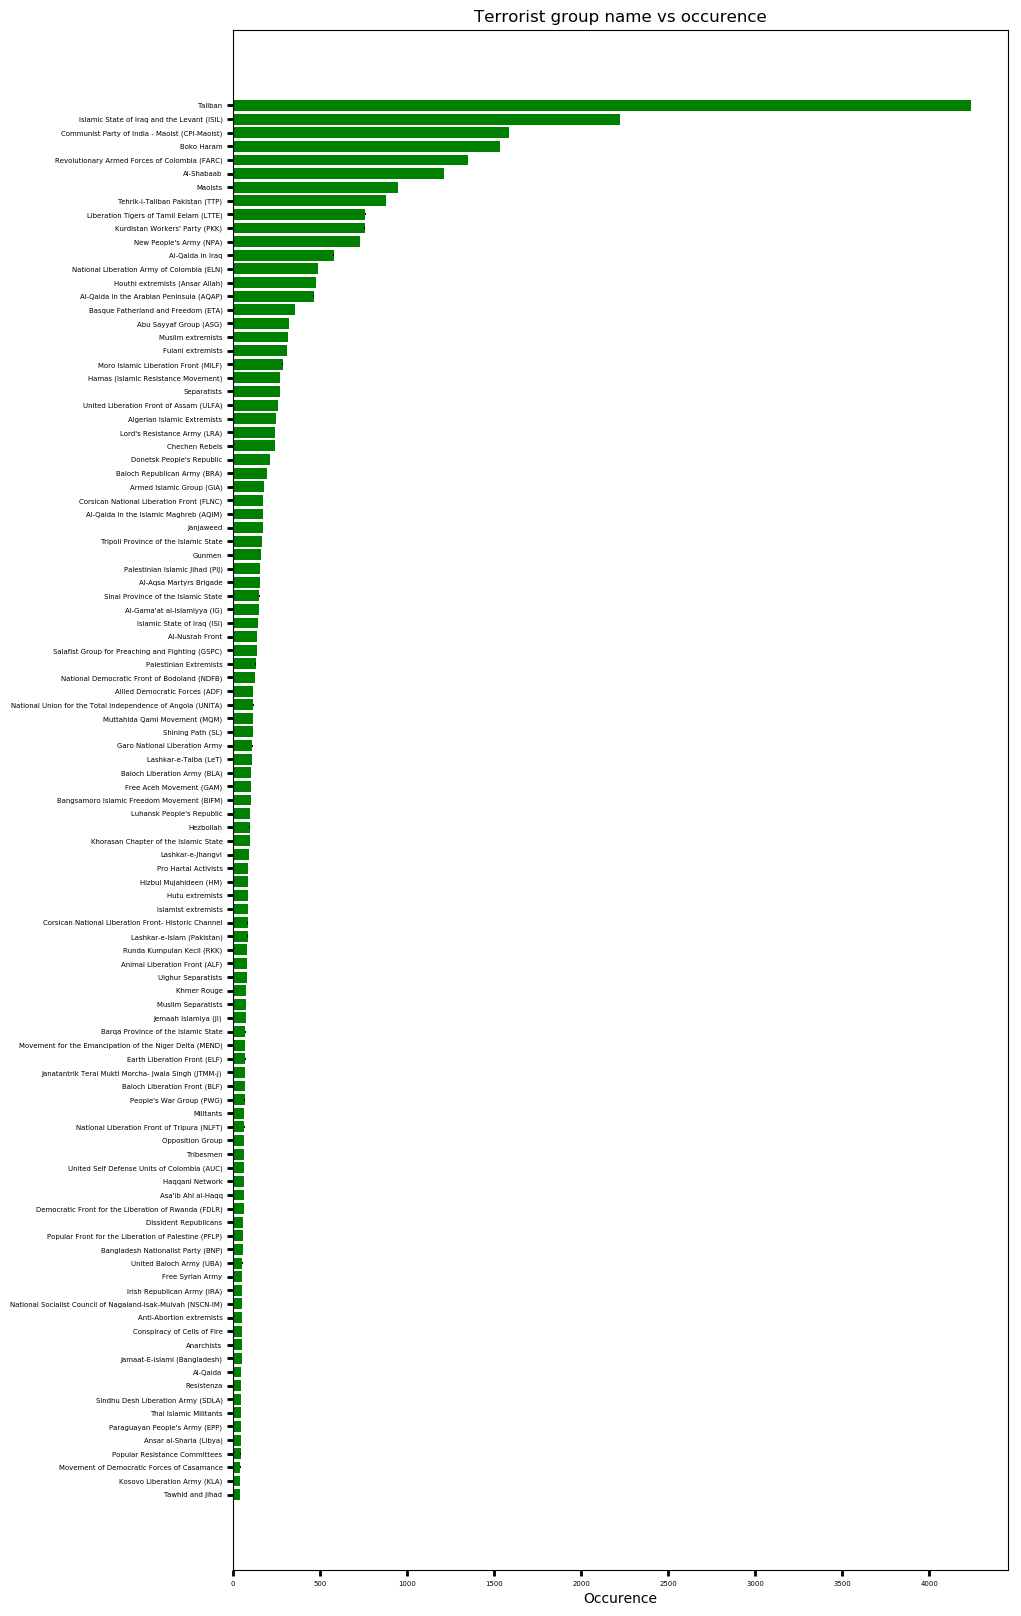

In [35]:
import matplotlib.pyplot as plt
import numpy as np

g_list = list(group_names)
# Fixing random state for reproducibility
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,20))
# Example data
people = g_list
y_pos = np.arange(len(people))
error = np.random.rand(len(people))
ax.barh(y_pos, values, xerr=error, align='center',
        color='green', ecolor='black')
ax.tick_params(direction='out', length=4, width=2, labelsize = 5, colors='black',
               grid_color='r', grid_alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurence')
ax.set_title('Terrorist group name vs occurence')

plt.show()

### Returning to preproccessing:
#### After we chop down the size of our dataframe by establishing our threshold, we can return to our text preproccessing. It is best to perform text preprocessing on the smallest amount of data possible. Recall that the datapoints on the graph were formed by running the logical sequence of notebook on other thresholds. we include the graph here for reference

The next few cells strip of punctuation and strip the name from the groups 

In [36]:
summarydate_list = []
body_list = []

for i in range(0,len(df)):
    s = df['summary'][i]
    summarydate_list.append(s[:s.find(':')])
    body_list.append(s[s.find(':'):])

#df['summarydate'] = summarydate_list
df['summary'] = body_list

df['summary'] = [string.replace(":", " ") for string in df['summary']]

In [37]:
def stripp(s): #function stripping punctuation
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s

# lowering and stripping punc. from df['summary']
df['summary'] = [item.lower() for item in df['summary']]
df['summary'] = [stripp(item) for item in df['summary']]

# lowering and stripping punc. from initial group_names, 
# saving as group_names1 to be used in matching 

group_names1 = [item.lower() for item in group_names]
group_names1 = [stripp(item) for item in group_names1]

In [38]:
newbody_list = []

for item1 in df['summary']:
    summ = str(item1)
    for item2 in group_names1:
        gname = str(item2) 
        if gname in summ:
            summ = summ.replace(gname, " ") 
    newbody_list.append(summ) #for every group appending to list
    
df['summary'] = newbody_list

In [39]:
# group_names is list of groups that exceed threshold, 
# so we will only filter those for our data frame.

df2 =  df[df['gname'].isin(group_names)] 

Confirming they are of all the same data type throughout the dataframe, and they are.

In [40]:
Counter(type(item) for item in df2['summary'])

Counter({str: 28404})


#### here we are checking the types contained in each column:

In [41]:
cols = list(df.columns)
for item1 in cols:
    print(Counter([type(item) for item in df[item1]]), item1)

Counter({<class 'numpy.float64'>: 34115}) eventid
Counter({<class 'numpy.int64'>: 34115}) iyear
Counter({<class 'numpy.int64'>: 34115}) imonth
Counter({<class 'numpy.int64'>: 34115}) iday
Counter({<class 'float'>: 32226, <class 'str'>: 1889}) approxdate
Counter({<class 'numpy.int64'>: 34115}) extended
Counter({<class 'float'>: 33385, <class 'str'>: 730}) resolution
Counter({<class 'numpy.int64'>: 34115}) country
Counter({<class 'str'>: 34115}) country_txt
Counter({<class 'numpy.int64'>: 34115}) region
Counter({<class 'str'>: 34115}) region_txt
Counter({<class 'str'>: 33426, <class 'float'>: 689}) provstate
Counter({<class 'str'>: 34018, <class 'float'>: 97}) city
Counter({<class 'numpy.float64'>: 34115}) latitude
Counter({<class 'numpy.float64'>: 34115}) longitude
Counter({<class 'numpy.float64'>: 34115}) specificity
Counter({<class 'numpy.int64'>: 34115}) vicinity
Counter({<class 'float'>: 20261, <class 'str'>: 13854}) location
Counter({<class 'str'>: 34115}) summary
Counter({<class '

#### upon examining this list we see that we should filter the appropriate columns as done in the line below. we do this because we want the datat to be consistent and of the same type throughout. further data engineering would need to be done to make other columns uniform, so we will see how our model fares using these already uniform features. 

In [42]:
df2 = df2.filter(items = ['country_txt', 'region_txt', 'provstate', 'city', 'location', 'suicide', 'attacktype1', 'targtype1_txt', 'targsubtype_txt', 'corp1','summary', 'gname'])

In [43]:
cat_List = ['country_txt', 'region_txt', 'provstate', 'city', 'suicide',
       'attacktype1', 'targtype1_txt', 'corp1','gname']

for col in cat_List:
    df2[col] = df2[col].astype('category') #type coersion to category categorical data dypte 
    #forcing to be not continous data.. 

In [44]:
cat_columns = df2.select_dtypes(['category']).columns 
df3 = df2[cat_columns].apply(lambda x: x.cat.codes) #makes it numbers

In [45]:
y = np.array([str(item) for item in df2['gname']])  # THIS IS THE LINE THAT GOT RID OF 
                                                    # the error: WEIGHTS NOT SUMMING TO ZERO
# Remove the labels from the features axis 1 refers to the columns
features= df3.drop(['gname'], axis = 1) 
feature_list = list(features.columns) #this way we remeber the column names
X_cat = np.array(features) #because once we convert to np array it drops the names

##### in the cell above we constructed "X_cat" to be our categorical features and below we will begin the process for our unstructured data features, which we are formatting into "bag of words" features, and then we will concatonate both of the structured features and unstructured features and see how the model fares.

#### For now: Checking accuracy on just structured data

In [46]:
# perfroming test train split on just the structured data
Xcat_train, Xcat_test, Y_train, Y_test = train_test_split(X_cat, y, test_size = 0.25, random_state = 42)

In [47]:
clf = RandomForestClassifier(random_state=0)
clf.fit(Xcat_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [48]:
len(clf.feature_importances_),len(feature_list)

(8, 8)

In [49]:
feature_list

['country_txt',
 'region_txt',
 'provstate',
 'city',
 'suicide',
 'attacktype1',
 'targtype1_txt',
 'corp1']

In [50]:
clf.feature_importances_

array([ 0.30810942,  0.13596396,  0.17616566,  0.12580512,  0.00759909,
        0.04734267,  0.0672858 ,  0.13172827])

In [51]:
feat_import = clf.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(feature_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')

In [52]:
from sklearn import metrics
true_labels = Y_test
predicted_labels = clf.predict(Xcat_test)
metrics.accuracy_score(true_labels, predicted_labels)

0.80383044641599777

Our accuracy is 0.8038 when only using the structured data

# 1) Random Forest Classifier: 

### adding bag of word / tfidf features and comparing

### with structured and unstructured data as features. first we obtain our "min df" for bag of words features.

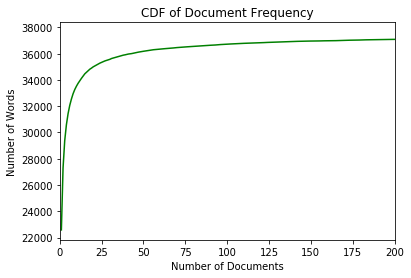

In [125]:
# this cell is to get min df:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0)

X = vectorizer.fit_transform(df2['summary']) #train it almost to create your vocab. call fit to build vocab
X = X.toarray()

# Get the counts of documents each word appears on 
count = []
for i in range(X.shape[1]):
    x = np.count_nonzero(X[:, i])
    count.append(x)
count = np.sort(count)

# Constructing X and Y axis
ind = [] #number of words
val = [] #number of documents
for i in np.arange(len(count)):
    if i != len(count)-1:
        if count[i] < count[i+1]:
            ind.append(i+1)
            val.append(count[i])
    else:
        ind.append(len(count))
        val.append(count[i])

# Plot the graph
plt.plot(val, ind, color='green')
plt.xlabel('Number of Documents')
plt.ylabel('Number of Words')
plt.title('CDF of Document Frequency')
plt.xlim(0, 200)
plt.show()

From this graph we see min df should be about 5. We want to choose our min df around when we would start to see the graph plateuing. If you make mindf too small then it will care about words that only exist in 1 document and if you make min df too large it will care about words that are in all of the documents, where we do not want to add words that are in all of the documents because then the feature wont be as indicative. 

In [54]:
df_cat = df3.drop(['gname'], axis = 1) 
X_cat = np.array(df_cat)
X_summ = np.array(df2['summary'])

In [55]:
len(X_cat),len(X_summ), len(df2['summary'])

(28404, 28404, 28404)

In [56]:
Xcat_train, Xcat_test, Xbow_train, Xbow_test, Y_train, Y_test = train_test_split(X_cat,X_summ, y, test_size = 0.25, random_state = 42)

In [57]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
# our pipeline is ready

In [58]:
norm_X_train = normalize_corpus(Xbow_train)
norm_X_test = normalize_corpus(Xbow_test)

 here we utilize min df = 5

In [60]:
vectorizer = CountVectorizer(min_df=5) 
tvectorizer = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True)

Xbow_train_features = vectorizer.fit_transform(Xbow_train) #train it almost to create your vocab. call fit to build vocab
Xbow_train_features = Xbow_train_features.toarray()
Xbow_train_df = pd.DataFrame(Xbow_train_features)

Xtf_train_features = tvectorizer.fit_transform(Xbow_train) #train it almost to create your vocab. call fit to build vocab
Xtf_train_features = Xtf_train_features.toarray()
Xtf_train_df = pd.DataFrame(Xtf_train_features)

In [61]:
Xbow_test_features = vectorizer.transform(Xbow_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
Xbow_test_features = Xbow_test_features.toarray()
Xbow_test_df = pd.DataFrame(Xbow_test_features)

Xtf_test_features = tvectorizer.transform(Xbow_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
Xtf_test_features = Xtf_test_features.toarray()
Xtf_test_df = pd.DataFrame(Xtf_test_features)

In [62]:
Xcat_train_df = pd.DataFrame(Xcat_train)
Xcat_test_df = pd.DataFrame(Xcat_test)

we here concatenate the two: Xcat_train_df and train_bow_df

In [63]:
mega_train_df = pd.concat([Xcat_train_df, Xbow_train_df], axis = 1)
mega_test_df = pd.concat([Xcat_test_df, Xbow_test_df], axis = 1)

In [82]:
megatf_train_df = pd.concat([Xcat_train_df, Xtf_train_df], axis = 1)
megatf_test_df = pd.concat([Xcat_test_df, Xtf_test_df], axis = 1)

checking the shape 

In [83]:
mega_train_df.shape, mega_test_df.shape, megatf_train_df.shape, megatf_test_df.shape 

((21303, 5937), (7101, 5937), (21303, 31607), (7101, 31607))

converting back to arrays because thats the datatype the Random Forest Classifier Model takes in.

In [84]:
X_mega_train = np.array(mega_train_df)
X_mega_test = np.array(mega_test_df)

In [85]:
Xtf_mega_train = np.array(megatf_train_df)
Xtf_mega_test = np.array(megatf_test_df)

fitting the model

In [86]:
clf1 = RandomForestClassifier(random_state=0)
clf1.fit(X_mega_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [87]:
clf2 = RandomForestClassifier(random_state=0)
clf2.fit(Xtf_mega_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [88]:
len(clf1.feature_importances_), len(clf2.feature_importances_)

(5937, 31607)

In [89]:
#make bar graph of feature importances.

In [90]:
feat_list = list(mega_train_df.columns) #mega train df
feat_listtf = list(megatf_train_df.columns) #mega train df

In [92]:
print(clf1.feature_importances_)
print(clf2.feature_importances_)

[ 0.06628675  0.03726086  0.02682645 ...,  0.00010719  0.          0.        ]
[ 0.03928129  0.02620571  0.02226276 ...,  0.          0.          0.        ]


In [93]:
# wait why are they different lengths?
len(feat_list),len(clf1.feature_importances_)

(5937, 5937)

In [94]:
cat_feat = list(df_cat.columns)
bow_feat = list(vectorizer.get_feature_names())
mega_feat_list = cat_feat + bow_feat

tf_feat = list(tvectorizer.get_feature_names())

mega_feat_list = cat_feat + bow_feat
megatf_feat_list = cat_feat + tf_feat

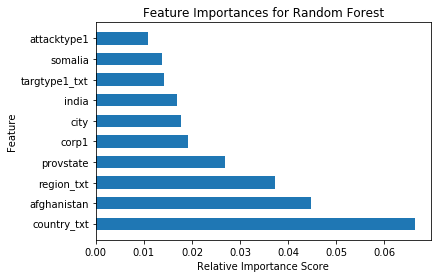

In [95]:
feat_import = clf1.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(mega_feat_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')

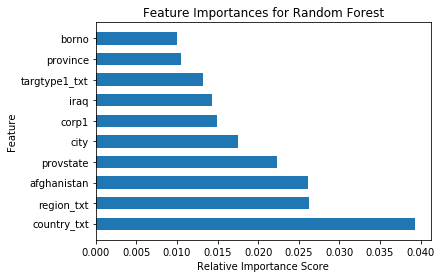

In [96]:
feat_import = clf2.feature_importances_
feature_names, feature_scores = zip(*sorted(zip(megatf_feat_list, feat_import), 
                                                          key=lambda x: -x[1]))
feature_names = feature_names[:10]
feature_scores = feature_scores[:10]
y_position = list(range(len(feature_names)))
plt.barh(y_position, feature_scores, height=0.6, align='center')
plt.yticks(y_position , feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest')

In [97]:
clf_predictions = meu.train_predict_model(classifier=clf1, 
                                             train_features=X_mega_train, train_labels=Y_train,
                                             test_features=X_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=clf_predictions,
                                      classes=group_names) #they have to match category labels
                                                           #gnames_list

Model Performance metrics:
------------------------------
Accuracy: 0.8692
Precision: 0.8698
Recall: 0.8692
F1 Score: 0.8609

Model Classification report:
------------------------------
                                                              precision    recall  f1-score   support

                                                     Taliban       0.96      0.99      0.98      1067
                 Islamic State of Iraq and the Levant (ISIL)       0.89      0.98      0.94       566
              Communist Party of India - Maoist (CPI-Maoist)       0.87      0.91      0.89       391
                                                  Boko Haram       0.95      1.00      0.97       375
               Revolutionary Armed Forces of Colombia (FARC)       0.86      0.94      0.90       337
                                                  Al-Shabaab       0.92      0.99      0.95       298
                                                     Maoists       0.76      0.90      0.83       2

                                                                     Predicted:  \
                                                                        Taliban   
Actual: Taliban                                                            1060   
        Islamic State of Iraq and the Levant (ISIL)                           0   
        Communist Party of India - Maoist (CPI-Maoist)                        0   
        Boko Haram                                                            0   
        Revolutionary Armed Forces of Colombia (FARC)                         0   
        Al-Shabaab                                                            1   
        Maoists                                                               1   
        Tehrik-i-Taliban Pakistan (TTP)                                       4   
        Liberation Tigers of Tamil Eelam (LTTE)                               0   
        Kurdistan Workers' Party (PKK)                                        0   
    

In [99]:
clf2_predictions = meu.train_predict_model(classifier=clf2, 
                                             train_features=Xtf_mega_train, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=clf2_predictions,
                                      classes=group_names) #they have to match category labels
                                                           #gnames_list

Model Performance metrics:
------------------------------
Accuracy: 0.8114
Precision: 0.8055
Recall: 0.8114
F1 Score: 0.797

Model Classification report:
------------------------------
                                                              precision    recall  f1-score   support

                                                     Taliban       0.91      0.99      0.95      1067
                 Islamic State of Iraq and the Levant (ISIL)       0.85      0.97      0.90       566
              Communist Party of India - Maoist (CPI-Maoist)       0.78      0.92      0.85       391
                                                  Boko Haram       0.87      0.98      0.92       375
               Revolutionary Armed Forces of Colombia (FARC)       0.78      0.91      0.84       337
                                                  Al-Shabaab       0.79      0.95      0.86       298
                                                     Maoists       0.74      0.79      0.76       24

                                                                     Predicted:  \
                                                                        Taliban   
Actual: Taliban                                                            1056   
        Islamic State of Iraq and the Levant (ISIL)                           1   
        Communist Party of India - Maoist (CPI-Maoist)                        0   
        Boko Haram                                                            0   
        Revolutionary Armed Forces of Colombia (FARC)                         0   
        Al-Shabaab                                                            4   
        Maoists                                                               2   
        Tehrik-i-Taliban Pakistan (TTP)                                      12   
        Liberation Tigers of Tamil Eelam (LTTE)                               1   
        Kurdistan Workers' Party (PKK)                                        2   
    

/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# perhaps the same can be done with tfidf to compare?

In [ ]:
len(group_names)

### 2) logistic regression

In [100]:
dummy_features = pd.get_dummies(df2[['country_txt','provstate','targtype1_txt']])

In [101]:
len(dummy_features)

28404

In [102]:
dummy_features.head()

,country_txt_Afghanistan,country_txt_Algeria,country_txt_Angola,country_txt_Argentina,country_txt_Australia,country_txt_Austria,country_txt_Bahrain,country_txt_Bangladesh,country_txt_Belgium,country_txt_Bosnia-Herzegovina,...,targtype1_txt_Police,targtype1_txt_Private Citizens & Property,targtype1_txt_Religious Figures/Institutions,targtype1_txt_Telecommunication,targtype1_txt_Terrorists/Non-State Militia,targtype1_txt_Tourists,targtype1_txt_Transportation,targtype1_txt_Unknown,targtype1_txt_Utilities,targtype1_txt_Violent Political Party
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
y = np.array([str(item) for item in df2['gname']])
#make sure that the y is names and not label encoded, but basically only the features need hot encoded 
features= dummy_features 
feature_list = list(dummy_features.columns) #this way we remeber the column names # Convert to numpy array
X_dummies = np.array(dummy_features) #because once we convert to np array it drops the names

In [104]:
dummy_df = pd.DataFrame(X_dummies)

In [106]:
len(Xcat_train_df),len(dummy_df)

(21303, 28404)

In [107]:
X_dummy = np.array(dummy_df)

In [108]:
Xdum_train, Xdum_test, Xsumm_train, Xsumm_test, Y_train, Y_test = train_test_split(X_dummy,X_summ, y, test_size = 0.25, random_state = 42)

In [109]:
Xdum_train.shape, Xdum_test.shape, Xsumm_train.shape, Xsumm_test.shape, Y_train.shape, Y_test.shape

((21303, 995), (7101, 995), (21303,), (7101,), (21303,), (7101,))

In [110]:
norm_X_train = normalize_corpus(Xsumm_train)
norm_X_test = normalize_corpus(Xsumm_test)

In [111]:
vectorizer = CountVectorizer(min_df=5)
tvectorizer = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True)

train_bow_features = vectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
train_bow_features = train_bow_features.toarray()

train_tf_features = tvectorizer.fit_transform(Xsumm_train) #train it almost to create your vocab. call fit to build vocab
train_tf_features = train_tf_features.toarray()

In [112]:
train_bow_df = pd.DataFrame(train_bow_features)
train_tf_df = pd.DataFrame(train_tf_features)

In [113]:
test_bow_features = vectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
test_bow_features = test_bow_features.toarray()
test_bow_df = pd.DataFrame(test_bow_features)

test_tf_features = vectorizer.transform(Xsumm_test) #difference betweeen transform and fit trans
#train it almost to create your vocab. call fit to build vocab
test_tf_features = test_tf_features.toarray()
test_tf_df = pd.DataFrame(test_tf_features)

In [114]:
Xdum_train_df = pd.DataFrame(Xdum_train)
Xdum_test_df = pd.DataFrame(Xdum_test)

In [117]:
mega_train_df = pd.concat([Xdum_train_df, train_bow_df], axis = 1)
megatf_train_df = pd.concat([Xdum_train_df, train_tf_df], axis = 1)

In [116]:
mega_test_df = pd.concat([Xdum_test_df, test_bow_df], axis = 1)
megatf_test_df = pd.concat([Xdum_test_df, test_tf_df], axis = 1)

In [118]:
mega_train_df.shape, mega_test_df.shape, megatf_train_df.shape, megatf_test_df.shape 

((21303, 6924), (7101, 6924), (21303, 32594), (7101, 6924))

In [119]:
X_mega = np.array(mega_train_df)
X_mega_test = np.array(mega_test_df)

In [120]:
Xtf_mega = np.array(megatf_train_df)
Xtf_mega_test = np.array(megatf_test_df)

In [121]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
lr = LogisticRegression(penalty='l2', max_iter=100, C=1) # penalty parameter and C parameter can be tuned
svm = SGDClassifier(loss='hinge', n_iter=100) #stochastic gradient descent svm

In [122]:
# Logistic Regression model on features
lr_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=X_mega, train_labels=Y_train,
                                             test_features=X_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=lr_predictions,
                                      classes=group_names) #they have to match category labels
#gnames_list

Model Performance metrics:
------------------------------
Accuracy: 0.9231
Precision: 0.9261
Recall: 0.9231
F1 Score: 0.921

Model Classification report:
------------------------------
                                                              precision    recall  f1-score   support

                                                     Taliban       0.98      0.99      0.99      1067
                 Islamic State of Iraq and the Levant (ISIL)       0.96      0.98      0.97       566
              Communist Party of India - Maoist (CPI-Maoist)       0.95      0.91      0.93       391
                                                  Boko Haram       0.99      1.00      0.99       375
               Revolutionary Armed Forces of Colombia (FARC)       0.90      0.94      0.92       337
                                                  Al-Shabaab       1.00      1.00      1.00       298
                                                     Maoists       0.87      0.95      0.91       24

                                                                     Predicted:  \
                                                                        Taliban   
Actual: Taliban                                                            1058   
        Islamic State of Iraq and the Levant (ISIL)                           0   
        Communist Party of India - Maoist (CPI-Maoist)                        0   
        Boko Haram                                                            0   
        Revolutionary Armed Forces of Colombia (FARC)                         0   
        Al-Shabaab                                                            0   
        Maoists                                                               0   
        Tehrik-i-Taliban Pakistan (TTP)                                       3   
        Liberation Tigers of Tamil Eelam (LTTE)                               0   
        Kurdistan Workers' Party (PKK)                                        0   
    

In [ ]:
meu.get_metrics(Y_test, lr_predictions)

### with dj

In [123]:
# Logistic Regression model on features
lrtf_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=Xtf_mega, train_labels=Y_train,
                                             test_features=Xtf_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=lrtf_predictions,
                                      classes=group_names) #they have to match category labels
#gnames_list

ValueError: X has 6924 features per sample; expecting 32594

In [124]:
meu.get_metrics(Y_test, lrtf_predictions)

NameError: name 'lrtf_predictions' is not defined

#### svm

the svm model took too long to train

In [ ]:
'''
# SVM model on features
svm_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=X_mega, train_labels=Y_train,
                                             test_features=X_mega_test, test_labels=Y_test)

meu.display_model_performance_metrics(true_labels=Y_test, predicted_labels=svm_predictions,
                                      classes=group_names) #they have to match category labels
'''